## CE-like background in offspill 

SAM definition: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root` 

First file: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root`

File lists: `/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.*.txt`

## Imports

Switched to using installed pyutils package

In [1]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

# sys.path.append("../../../EventNtuple/utils/pyutils")
from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse

## Set file output tag

In [2]:
# Get today's date in MM-DD-YY format
today = datetime.now().strftime("%m-%d-%y")
# tag = "test_plot" # today
tag = today
spill = "offspill"

# Create Processor 

We inherit from Skeleton - this gives us many pre-built methods without writing extra code

In [3]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        # self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "//exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_24.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_file_list.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/background_files.txt"
        # self.file_name = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00024906.root"
        self.file_name = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFiles/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00000035.root"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = False     # Use remote file via mdh
        self.location = "disk"     # File location
        self.max_workers = 1      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=False,
            verbosity=0
        )

        # Toggle cuts OFF 
        self.inactive_cuts = [ 
            "has_hits",
            "within_lhr_max",
            "within_d0",
            "within_pitch_angle"
        ]
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(
                data=this_data, 
                file_id=file_name,
                inactive_cuts=self.inactive_cuts
            )

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

    ## Need postprocessing and failure handling!   


# Create an instance of our custom processor
cosmic_processor = CosmicProcessor()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised


In [4]:
# ==========================================
# Run the processor
# ==========================================

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# This starts a parent Processor and submits the process function to the threads

# Execute your processor
results = cosmic_processor.execute()

[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = False
	verbosity=2
[pyprocess] ✅ Returning result from process on /exp/mu2e/data/users/sgrant/pyutils-test/TestFiles/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00000035.root
[Skeleton] ✅ Analysis complete


## Check results

In [5]:
# This handles single files 
if not isinstance(results, list):
    results = [results]

print(results[0])

{'file_id': '/exp/mu2e/data/users/sgrant/pyutils-test/TestFiles/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00000035.root', 'cut_stats': [{'name': 'No cuts', 'active': 'N/A', 'description': 'No selection applied', 'events_passing': 6984, 'absolute_frac': 100.0, 'relative_frac': 100.0}, {'name': 'is_truth_electron', 'active': True, 'description': 'Track parents are electrons (truth PID)', 'mask': <Array [[False, False, False, False], ..., [...]] type='6984 * var * ?bool'>, 'events_passing': 2777, 'absolute_frac': 39.762313860252, 'relative_frac': 39.762313860252}, {'name': 'is_reco_electron', 'active': True, 'description': 'Tracks are assumed to be electrons (trk)', 'mask': <Array [[False, False, False, False], ..., [...]] type='6984 * var * ?bool'>, 'events_passing': 2560, 'absolute_frac': 36.65521191294387, 'relative_frac': 92.18581202736766}, {'name': 'one_reco_electron', 'active': True, 'description': 'One reco electron / event', 'mask': <Arr

## Print cut statistics

In [6]:
# Helper to convert the cut stats into a list 
def get_stats_list(results):
    stats = [] 
    if isinstance(results, list): 
        for result in results: 
            if "cut_stats" in result: 
                stats.append(result["cut_stats"])
    else: 
        stats.append(results["cut_stats"])
    return stats

stats = get_stats_list(results)

cut_manager = CutManager()
combined_stats = cut_manager.combine_cut_stats(stats)
cut_manager.print_cut_stats(stats=combined_stats, active_only=True, csv_name=f"../../txt/cut_stats_{spill}_{tag}.csv")

[CutManager] ⭐️ Cut statistics
--------------------------------------------------------------------------------------------------------------
Cut                  Events passing       Absolute frac. [%]   Relative frac. [%]   Description                   
--------------------------------------------------------------------------------------------------------------
No cuts              6984                 100.00               100.00               No selection applied          
is_truth_electron    2777                 39.76                39.76                Track parents are electrons (truth PID)
is_reco_electron     2560                 36.66                92.19                Tracks are assumed to be electrons (trk)
one_reco_electron    1689                 24.18                65.98                One reco electron / event     
good_trkqual         651                  9.32                 38.54                Track quality (quality > 0.8) 
downstream           528              

In [7]:
# results[0].keys()

## Print concise background event information 

In [8]:
output = []

for i, result in enumerate(results): 
    
    data = ak.Array(result["filtered_data"])
    
    if len(data) == 0:
        continue

    selector = Select(verbosity=0)
    trk_front = selector.select_surface(data["trkfit"], sid=0)
    track_time = data["trkfit"]["trksegs"]["time"][trk_front]
    coinc_time = data["crv"]["crvcoincs.time"]
    
    # Extract values
    track_time_str = "" 
    coinc_time_str = ""
    
    # Extract floats from track_time (nested structure: [[[values]], [[values]]])
    track_floats = []
    for nested in track_time:
        for sublist in nested:
            for val in sublist:
                track_floats.append(float(val))
    
    # Extract floats from coinc_time (structure: [[], []])
    coinc_floats = []
    for sublist in coinc_time:
        for val in sublist:
            coinc_floats.append(float(val))
    
    # Format as strings with precision
    if track_floats:
        track_time_str = ", ".join([f"{val:.6f}" for val in track_floats])
    
    if coinc_floats:
        coinc_time_str = ", ".join([f"{val:.6f}" for val in coinc_floats])

    # Calculate dt
    dt_str = ""
    if track_floats and coinc_floats:
        # Calculate dt between first track time and first coinc time
        dt_value = abs(track_floats[0] - coinc_floats[0])
        dt_str = f"{dt_value:.6f}"
    
    output.append(f"  Index:            {i}")
    output.append(f"  Subrun:           {data["evt"]["subrun"]}")
    output.append(f"  Event:            {data["evt"]["event"]}")
    output.append(f"  File:             {result["file_id"]}")
    output.append(f"  Track time [ns]:  {track_time_str}") # data["trkfit"]["trksegs"]["time"]}")
    output.append(f"  Coinc time [ns]:  {coinc_time_str if len(coinc_time_str)>0 else None}") # data["crv"]["crvcoincs.time"]}")
    output.append(f"  dt [ns]:          {dt_str if len(dt_str)>0 else "N/A"}")
    output.append("-" * 40)

output = "\n".join(output)

# Print 
# print(output)

# Write to file
fout_name = f"../../txt/{spill}/background_events_{tag}.txt"
with open(fout_name, "w") as f:
    f.write(output)

print(f"\tWrote {fout_name}")

	Wrote ../../txt/offspill/background_events_06-20-25.txt


In [9]:
!mkdir ../../txt/offspill/

mkdir: cannot create directory ‘../../txt/offspill/’: File exists


## Draw histograms 

Momentum and z-position

In [10]:
# Should be in postprocessing 

def combine_histograms(results):
    """Combine histograms from multiple files
    
    Args:
        file_results: Dictionary with file IDs as keys and results as values
                     Each result contains a 'histograms' dict
    
    Returns:
        dict: Combined histograms
    """
    combined_hists = {}
    
    # Check if we have results
    if not results:
        return None
    
    # Loop through all files
    for result in results: # 
        # Skip if no histograms in this file
        if 'histograms' not in result or not result['histograms']:
            continue
        
        # Process each histogram type
        for hist_name, hist_obj in result['histograms'].items():
            if hist_name not in combined_hists:
                # First time seeing this histogram type, initialise
                combined_hists[hist_name] = hist_obj.copy()
            else:
                # Add this histogram to the accumulated one
                combined_hists[hist_name] += hist_obj

    return combined_hists

# Combine hists 
combined_histograms = combine_histograms(results)

In [11]:
combined_histograms

{'Wide range': Hist(
   Regular(30, 0, 300, name='momentum', label='Momentum [MeV/c]'),
   StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
   storage=Double()) # Sum: 39435.0 (39679.0 with flow),
 'Signal region': Hist(
   Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
   StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
   storage=Double()) # Sum: 264.0,
 'CRV z-position': Hist(
   Regular(100, -15000, 10000, name='crv_z', label='CRV z-position [mm]'),
   StrCategory(['All', 'CE-like', 'Unvetoed CE-like'], name='selection', label='Selection'),
   storage=Double()) # Sum: 8419.0}

### Momentum plots

/home/dorojan/.conda/envs/mu2e_env/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


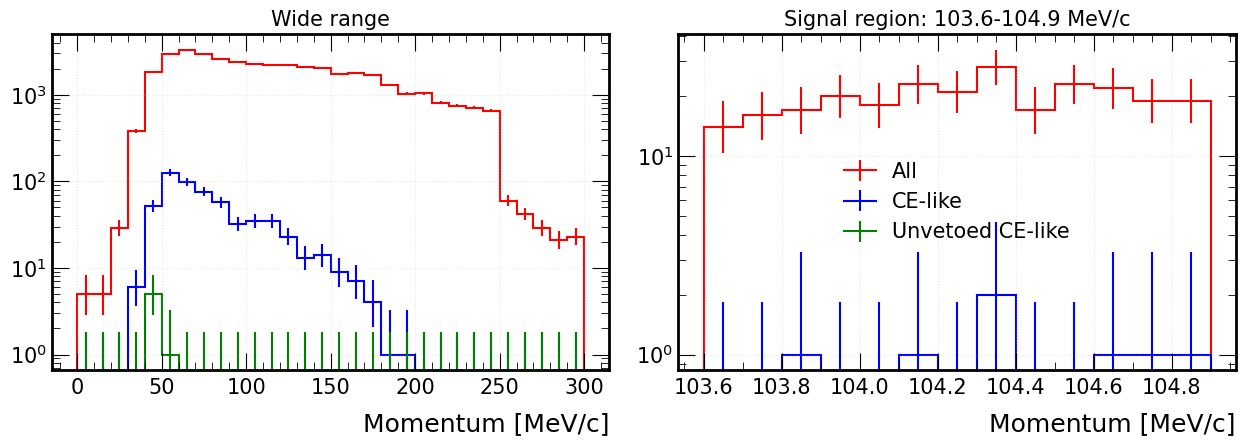

In [12]:
def mom_plots(fout=f"../../img/{spill}/h1_ana_mom_{spill}_{tag}.png"):

    # Now you can plot them
    fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
    
    # Plot wide range in first subplot
    h_wide = combined_histograms['Wide range']
    # Can also include "CE-like tracks"
    # h_wide = h_wide[{"selection": ["All", "CE-like", "Unvetoed CE-like"]}] # slice(-2, None)}]  # Last 2 selections
    h_wide.plot1d(overlay='selection', ax=ax[0])
    # h_wide.sum().value
    ax[0].set_title("Wide range")
    ax[0].set_yscale('log')
    ax[0].grid(True, alpha=0.3)
    # ax[0].legend(frameon=False, loc="best")

# Plot signal region in second subplot
    h_signal = combined_histograms['Signal region']
    
    # h_signal = h_signal[{"selection": ["All", "CE-like", "Unvetoed CE-like"]}] 
    h_signal.plot1d(overlay='selection', ax=ax[1])
    ax[1].set_title("Signal region: 103.6-104.9 MeV/c")
    ax[1].set_yscale('log')
    ax[1].grid(True, alpha=0.3)
    ax[1].set_ylabel("")  # Remove duplicate y-label
    ax[1].legend(frameon=False, loc="best")

    plt.tight_layout()
    plt.savefig(fout, dpi=300)
    plt.show()

mom_plots()

In [13]:
!mkdir /exp/mu2e/data/users/dorojan/mu2e_cosmic_ana/img/offspill/

mkdir: cannot create directory ‘/exp/mu2e/data/users/dorojan/mu2e_cosmic_ana/img/offspill/’: File exists


### z-position plots

/home/dorojan/.conda/envs/mu2e_env/lib/python3.12/site-packages/hist/basehist.py:444: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/tmp/ipykernel_1022263/1450551078.py:47: RuntimeWarning: invalid value encountered in divide
  ratio = h_ce.values() / h_all.values()


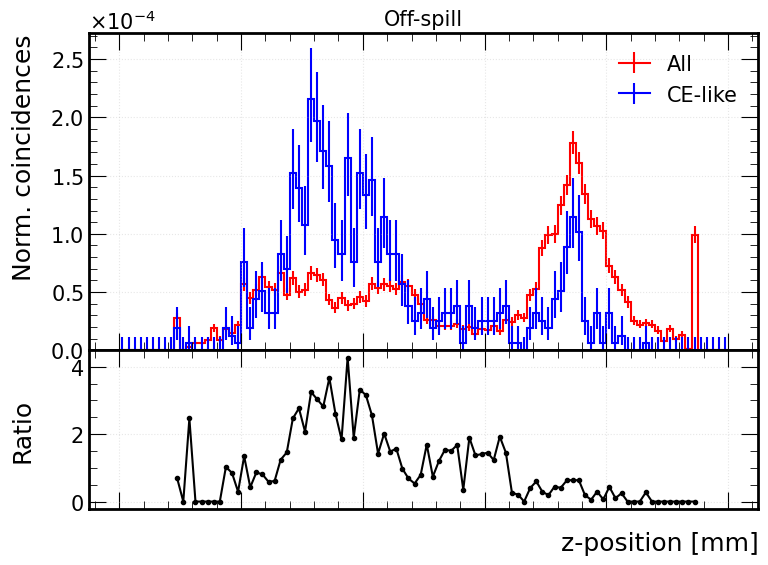

Wrote ../../img/offspill/h1_ana_crv_z_offspill_06-20-25.png


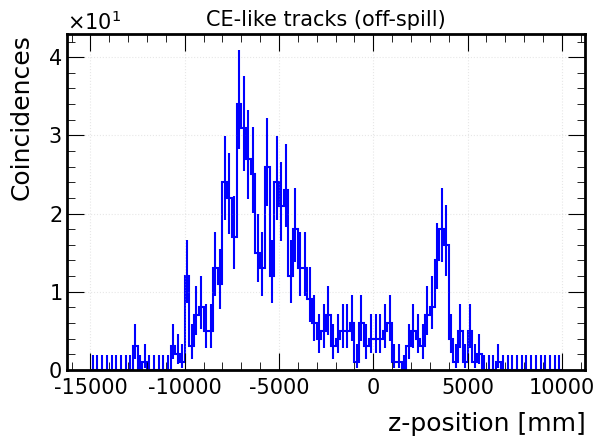

Wrote ../../img/offspill/h1_ana_crv_z_offspill_06-20-25_ce_only.png


In [14]:
# def z_plots(fout=f"../../img/{spill}/h1_ana_crv_z_{spill}_{tag}.png"):
#     fig, ax = plt.subplots() 
#     h_wide = combined_histograms['CRV z-position']
#     # Can also include "CE-like tracks"
#     h_wide = h_wide[{"selection": ["All", "CE-like"]}] # slice(-2, None)}]  # Last 2 selections
#     h_wide.plot1d(overlay='selection', ax=ax)
#     # h_wide.sum().value
#     ax.set_ylabel("Coincidences")
#     ax.set_xlabel("z-position [mm]")
#     ax.set_yscale("log")
#     ax.grid(True, alpha=0.3)
#     ax.legend(frameon=False, loc="best")
#     plt.tight_layout()
#     plt.savefig(fout, dpi=300)
#     plt.show()

def z_plots(fout=f"../../img/{spill}/h1_ana_crv_z_{spill}_{tag}.png"):
    fig, (ax_main, ax_ratio) = plt.subplots(
        2, 1, figsize=(6.4*1.25, 4.8*1.25), 
        gridspec_kw={'height_ratios': [2, 1], 'hspace': 0},
        sharex=True  # This ensures alignment
    )
    
    h_wide = combined_histograms['CRV z-position']
    h_wide = h_wide[{"selection": ["All", "CE-like"]}]
    
    # Main plot
    h_wide.plot1d(overlay='selection', ax=ax_main, density=True)
    ax_main.set_ylabel("Norm. coincidences")
    # ax_main.set_yscale("log")
    ax_main.grid(True, alpha=0.3)
    ax_main.legend(frameon=False, loc="best")
    ax_main.set_xlabel("")  # Remove x-label from main plot
    ax_main.set_xticklabels([])
    ax_main.set_title("Off-spill")

    ax_main.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    
    # Ratio plot
    h_all = h_wide[{"selection": "All"}] 
    h_ce = h_wide[{"selection": "CE-like"}]

    h_all = h_all / h_all.sum()
    h_ce = h_ce / h_ce.sum()
    
    # Calculate ratio (CE-like / All)
    ratio = h_ce.values() / h_all.values()
    bin_centers = h_ce.axes[0].centers
    
    ax_ratio.plot(bin_centers, ratio, 'ko-', markersize=3)
    # ax_ratio.axhline(y=1, color='red', linestyle='--', alpha=0.7)
    
    ax_ratio.set_ylabel("Ratio", va='center',ha='center')
    ax_ratio.set_xlabel("z-position [mm]")
    ax_ratio.grid(True, alpha=0.3)
    # ax_ratio.set_ylim(0, 2) 

    # Align y-axis labels horizontally
    # ax_main.yaxis.set_label_coords(-0.1, 0.5)
    ax_ratio.yaxis.set_label_coords(-0.1, 0.5)

    plt.tight_layout()
    plt.savefig(fout, dpi=300)
    plt.show()

    print(f"Wrote {fout}")

    # Separate CE-like only plot
    fig_ce, ax_ce = plt.subplots() # figsize=(6.4*1.25, 4.8*1.25))
    
    h_ce_only = combined_histograms['CRV z-position'][{"selection": "CE-like"}]
    h_ce_only.plot1d(ax=ax_ce, density=False, color='blue')  # Or whatever color you prefer
    
    ax_ce.set_ylabel("Coincidences")
    ax_ce.set_xlabel("z-position [mm]")
    ax_ce.set_title("CE-like tracks (off-spill)")
    ax_ce.grid(True, alpha=0.3)
    ax_ce.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    
    plt.tight_layout()
    
    # Save CE-like plot with modified filename
    fout_ce = fout.replace(".png", "_ce_only.png")
    plt.savefig(fout_ce, dpi=300)
    plt.show()

    print(f"Wrote {fout_ce}")

z_plots()

In [15]:
# def z_plots(fout=f"../../img/{spill}/h1_ana_crv_z_{spill}_{tag}.png"):
#     fig, (ax_main, ax_ratio) = plt.subplots(
#         2, 1, figsize=(6.4*1.25, 4.8*1.25), 
#         gridspec_kw={'height_ratios': [2, 1], 'hspace': 0},
#         sharex=True  # This ensures alignment
#     )
    
#     h_wide = combined_histograms['CRV z-position']
#     h_wide = h_wide[{"selection": ["All", "CE-like"]}]
    
#     # Main plot
#     h_wide.plot1d(overlay='selection', ax=ax_main, density=True)
#     ax_main.set_ylabel("Norm. coincidences")
#     ax_main.grid(True, alpha=0.3)
#     ax_main.legend(frameon=False, loc="best")
#     ax_main.tick_params(labelbottom=False)  # Hide x-tick labels instead
#     ax_main.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    
#     # Ratio plot
#     h_all = h_wide[{"selection": "All"}] 
#     h_ce = h_wide[{"selection": "CE-like"}]
#     h_all = h_all / h_all.sum()
#     h_ce = h_ce / h_ce.sum()
    
#     ratio = h_ce.values() / h_all.values()
#     bin_centers = h_ce.axes[0].centers
    
#     ax_ratio.plot(bin_centers, ratio, 'ko-', markersize=3)
#     ax_ratio.set_ylabel("Ratio", va='center', ha='center')
#     ax_ratio.set_xlabel("z-position [mm]")
#     ax_ratio.grid(True, alpha=0.3)
#     ax_ratio.yaxis.set_label_coords(-0.1, 0.5)
    
#     plt.tight_layout()
#     plt.savefig(fout, dpi=300)
#     plt.show()

# z_plots()

## Calculate counts and efficiency

In [16]:
# Calculate counts and efficiency

def count_events(label):
    h = combined_histograms["Wide range"]
    h = h[{'selection': label}]  
    return int(h.sum())

all_count = count_events("All")
ce_like_count = count_events("CE-like") 
unvetoed_count = count_events("Unvetoed CE-like")

efficiency = 100 * (1 - unvetoed_count / ce_like_count) if ce_like_count > 0 else np.nan
efficiency_error = 100 * np.sqrt(unvetoed_count) / ce_like_count if ce_like_count > 0 else np.nan

# Create formatted output
print("-" * 31)
print(f"{'Type':<20} {'Count':>10}")
print("-" * 31)
print(f"{'All':<20} {all_count:>10}")
print(f"{'CE-like':<20} {ce_like_count:>10}")
print(f"{'Unvetoed CE-like':<20} {unvetoed_count:>10}")
print("-" * 31)
print(f"Efficiency: {efficiency:.2f}±{efficiency_error:.2f}%")
print("-" * 31)

# Create pandas DataFrame and save to CSV
data = {
    'Type': ['All', 'CE-like', 'Unvetoed CE-like'],
    'Count': [all_count, ce_like_count, unvetoed_count]
}

# Add efficiency row
efficiency_data = {
    'Type': ['Efficiency [%]'],
    'Count': [f"{efficiency:.2f}±{efficiency_error:.2f}"]
}

df = pd.DataFrame(data)
df_efficiency = pd.DataFrame(efficiency_data)
df_combined = pd.concat([df, df_efficiency], ignore_index=True)

# Save to CSV 
fout = f"../../txt/{spill}/efficiency_{tag}.csv"
df_combined.to_csv(fout, index=False)

print(f"Wrote {fout}")

-------------------------------
Type                      Count
-------------------------------
All                       38840
CE-like                     589
Unvetoed CE-like              6
-------------------------------
Efficiency: 98.98±0.42%
-------------------------------
Wrote ../../txt/offspill/efficiency_06-20-25.csv


In [17]:
def count_events(label):
    h = combined_histograms["Signal region"] 
    h = h[{'selection': label}]  
    return int(h.sum())

all_count = count_events("All")
ce_like_count = count_events("CE-like") 
unvetoed_count = count_events("Unvetoed CE-like")

efficiency = 100 * (1 - unvetoed_count / ce_like_count)
efficiency_error = 100 * np.sqrt(unvetoed_count) / ce_like_count

# Create formatted output
print("-" * 31)
print(f"{'Type':<20} {'Count':>10}")
print("-" * 31)
print(f"{'All':<20} {all_count:>10}")
print(f"{'CE-like':<20} {ce_like_count:>10}")
print(f"{'Unvetoed CE-like':<20} {unvetoed_count:>10}")
print("-" * 31)
print(f"Efficiency: {efficiency:.2f}±{efficiency_error:.2f}%")
print("-" * 31)

# Create pandas DataFrame and save to CSV
data = {
    'Type': ['All', 'CE-like', 'Unvetoed CE-like'],
    'Count': [all_count, ce_like_count, unvetoed_count]
}

# Add efficiency row
efficiency_data = {
    'Type': ['Efficiency [%]'],
    'Count': [f"{efficiency:.2f}±{efficiency_error:.2f}"]
}

df = pd.DataFrame(data)
df_efficiency = pd.DataFrame(efficiency_data)
df_combined = pd.concat([df, df_efficiency], ignore_index=True)

# Save to CSV 
fout = f"../../txt/{spill}/efficiency_signal_{tag}.csv"
df_combined.to_csv(fout, index=False)

print(f"Wrote {fout}")

-------------------------------
Type                      Count
-------------------------------
All                         257
CE-like                       7
Unvetoed CE-like              0
-------------------------------
Efficiency: 100.00±0.00%
-------------------------------
Wrote ../../txt/offspill/efficiency_signal_06-20-25.csv


## Combine unvetoed data array

For detailed analysis

In [18]:
def combine_arrays(results):
    """Combine filtered arrays from multiple files
    """
    arrays_to_combine = []
    # Check if we have results
    if not results:
        return None
    # Loop through all files
    for result in results: #
        array = ak.Array(result["filtered_data"])
        if len(array) == 0:
            continue
        # Concatenate arrays
        arrays_to_combine.append(array)
    return ak.concatenate(arrays_to_combine)
    
data = combine_arrays(results)

In [19]:
vector = Vector()

[pyvector] ⭐️ Initialised Vector with verbosity = 1


In [20]:
help(vector.get_mag)

Help on method get_mag in module pyutils.pyvector:

get_mag(branch, vector_name) method of pyutils.pyvector.Vector instance
    Return an array of vector magnitudes for specified branch

    Args:
        branch (awkward.Array): The branch, such as trgsegs or crvcoincs
        vector_name: The parameter associated with the vector, such as 'mom' or 'pos'



[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


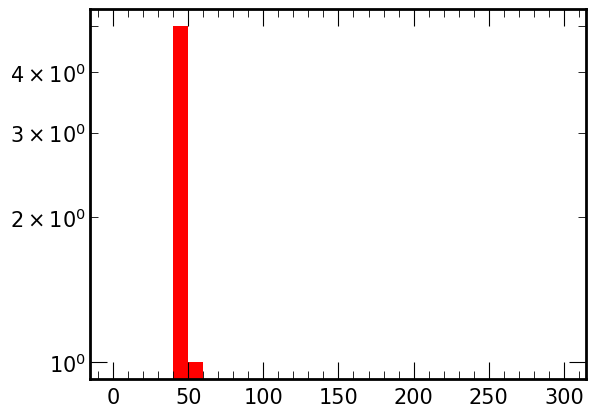

[41.9, 41.9, 49.7, 46.6, 51.4, 46.8]


In [21]:
s = Select()
trkent = s.select_surface(data["trkfit"],sid=0)
mom=vector.get_mag(data["trkfit"]["trksegs"][trkent],"mom")
mom=ak.flatten(mom,axis=None)
bins = np.linspace(0, 300, 31)  # 31 edges = 30 bins
plt.hist(mom, bins=bins)
# plt.hist(mom,bins=31)
plt.yscale("log")
# plt.xlim(0,300)
plt.show()
print(mom)

## Write out verbose background event info

In [22]:
# new = list(data["evt"]["event"])
# old = [157431, 283585, 465577, 216096, 359830, 439475, 377360, 38729, 161916, 217055]
# list(set(old) - set(new))

In [23]:
printer = Print(verbose=True)

fout = f"../../txt/{spill}/background_events_verbose_{tag}.txt"
import sys 
# Redirect stdout to file
with open(fout, "w") as f:
    old_stdout = sys.stdout
    sys.stdout = f
    printer.print_n_events(data, n_events=len(data))
    # Restore stdout
    sys.stdout = old_stdout
    print(f"Wrote {fout}")

[pyprint] ⭐️ Initialised Print with verbose = True and precision = 1
Wrote ../../txt/offspill/background_events_verbose_06-20-25.txt


## Find parent cosmic particle ID

These are `trkmcsim` entries of rank -1, with the highest momentum. 

In [24]:
data = combine_arrays(results)
vector = Vector()

def is_cosmic_parent(data): 
    # Rank condition
    rank_condition = data["trkmc"]["trkmcsim"]["rank"] == -1
    # Then by momentum 
    mom_mag = vector.get_mag(data["trkmc"]["trkmcsim"], "mom")
    data["mom_mag"] = mom_mag
    mom_condition = mom_mag == ak.max(mom_mag, axis=-1)
    # Combine
    mask = rank_condition & mom_condition
    return mask
    
cosmic_parent_mask = is_cosmic_parent(data)
data["cosmic_parent"] = cosmic_parent_mask

# # # # print(cosmic_parent_mask)
data["trkmc"] = data["trkmc"][cosmic_parent_mask]
data["mom_mag"] = data["mom_mag"][cosmic_parent_mask]

# printer.print_n_events(data, n_events=len(data))

# For some reason we have duplicates in here, so just take the first one 
cosmic_parent_pdg = ak.flatten(data["trkmc"]["trkmcsim"]["pdg"][:,:,0])
print("cosmic_parent_pdg", cosmic_parent_pdg) 


[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
cosmic_parent_pdg [13, 13, 13, 13, 13]


	Wrote ../../img/offspill/bar_cosmic_parents_06-20-25.png


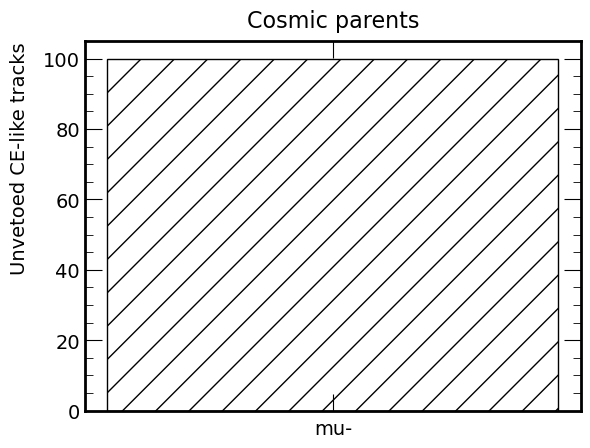

In [25]:
pdg_to_label = {
    11: "e-", -11: "e+",
    13: "mu-", -13: "mu+", 
    2112: "neutron", -2112: "antineutron",
    2212: "proton", -2212: "antiproton",
    22: "gamma", 111: "pi0",
    211: "pi+", -211: "pi-"
}

def BarChart(data, label_dict, title=None, xlabel=None, ylabel=None, fout="bar_chart.png", percentage=True, bar_alpha=1.0, bar_color='black', NDPI=300):
    """ Pulled from Mu2eCool repo 
    Needs update, but it works fine"""
    
    # Matches the key of the dict with row in the data array and returns the element as the label
    labels = [label_dict.get(p, 'other') for p in data]

    # Count occurrences of each label
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Only works for particles 

    # Sort labels and counts in descending order
    sorted_indices = np.argsort(label_counts)[::-1]
    unique_labels = unique_labels[sorted_indices]
    label_counts = label_counts[sorted_indices]

    if percentage: 
        label_counts = (label_counts / np.sum(label_counts))*100

    plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
    
    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot the bar chart
    indices = np.arange(len(unique_labels))

    # TODO: handle this better
    n_bars = len(indices)
    bar_width = 3.0 / n_bars
    if(n_bars == 3.0): 
        bar_width = 2.0 / n_bars
    elif(n_bars == 2.0):
        bar_width = 1.0 / n_bars

    ax.bar(indices, label_counts, align='center', alpha=bar_alpha, color=bar_color, width=bar_width, fill=False, hatch='/', linewidth=1, edgecolor='black')

    # Set x-axis labels
    ax.set_xticks(indices)
    ax.set_xticklabels(unique_labels, rotation=0) # 45)

    # Set labels for the chart
    ax.set_title(title, fontsize=16, pad=10)
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=14)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=14)  # Set y-axis tick label font size

    if ax.get_ylim()[1] > 999:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(14)

    # Save the figure
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    print("\tWrote", fout)


BarChart(
    cosmic_parent_pdg,
    pdg_to_label,
    title="Cosmic parents",
    ylabel="Unvetoed CE-like tracks",
    fout=f"../../img/{spill}/bar_cosmic_parents_{tag}.png"
    
)

In [26]:
cosmic_parent_pdg

<Array [13, 13, 13, 13, 13] type='5 * ?int32'>